### 200 Moving Day Average Crossover

##### Strategy: if there is a crossover between the 50 day moving average and the 200 day moving average, where the 50 day moving average is greater than the 200 day moving average, and there is high volumethen purchace $1000 worth of shares from that company. 

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from alpaca.trading.client import TradingClient
from alpaca.trading.requests import GetAssetsRequest
from alpaca.trading.requests import MarketOrderRequest
from alpaca.trading.enums import OrderSide, TimeInForce
from alpaca.trading.requests import MarketOrderRequest, LimitOrderRequest
from alpaca.data.historical import StockHistoricalDataClient
from alpaca_trade_api.rest import REST
from datetime import datetime
import time
from datetime import timedelta
import pytz


API_KEY = "PKNXRGRC2A6PAVABSRKP"
SECRET_KEY = "NjfSwiQ3lb431zYfyPRaCA2PfTAhySdMV6M1Ot0S"
trading_client = TradingClient(API_KEY, SECRET_KEY, paper=True)
data_client = StockHistoricalDataClient(API_KEY, SECRET_KEY)
api = REST(API_KEY, SECRET_KEY, base_url='https://paper-api.alpaca.markets')


#### Get S&P 500

In [2]:
# Wikipedia URL containing the current S&P 500 companies list
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

# Load the table containing S&P 500 companies into a DataFrame
tables = pd.read_html(url)

# The table we want is usually the first one
sp500_table = tables[0]

# Extract the ticker symbols
sp500_stocks = sp500_table['Symbol']
positions = api.list_positions()


In [24]:
#return whether or not stock is present in portfolio
def have_stock(stock) -> bool:
    try:
        # Check if the stock is in the portfolio
        return any(position.symbol == stock for position in positions)
    except Exception as e:
        print(f"Error checking stock: {e}")
        return False

#return whether or not there is a high volumne

def check_volume(stock_data) -> bool:
    latest_volume = stock_data['Volume'].iloc[-1]  
    high_volume_threshold = 10000000  # Example threshold for high volume
    return latest_volume > high_volume_threshold

def signal_generator(stock, stock_data, date) -> int:
    try:
        # # Try downloading data with 1 year period, fallback to 3 months if it fails
        # stock_data = yf.download(stock, end=date, period='1y', interval='1d')
        
        if stock_data.empty:
            print(f"SIGNAL:No data available for {stock}, skipping...")
            return 0
        
    except Exception as e:
        print(f"SIGNAL: Error downloading {stock}: {e}. Trying with a shorter period.")
        
        # Try a shorter period (e.g., 3 months)
        try:
            stock_data = yf.download(stock, period='3mo', interval='1d')
            if stock_data.empty:
                print(f"SIGNAL:No data available for {stock} in the 3-month period, skipping...")
                return -2
        except Exception as e:
            print(f"SIGNAL: Error downloading {stock} with shorter period: {e}")
            return -2
    
    # Calculate the moving averages, ensuring enough data is available
    if len(stock_data) < 200:
        print(f"SIGNAL: Not enough data for {stock} to calculate 200-day moving average.")
        return 0  # Not enough data for 200-day MA calculation
    
    stock_data['50_day_MA'] = stock_data['Close'].rolling(window=50).mean()
    stock_data['200_day_MA'] = stock_data['Close'].rolling(window=200).mean()
    
    last_row = stock_data.tail(1)
    
    # Check if last row is empty or missing moving averages
    if last_row.empty or pd.isna(last_row['50_day_MA'].iloc[0]) or pd.isna(last_row['200_day_MA'].iloc[0]):
        print(f"SIGNAL: Error calculating moving averages for {stock}, skipping...")
        return 0
    
    move_avg_50 = last_row["50_day_MA"].iloc[0]
    move_avg_200 = last_row["200_day_MA"].iloc[0]

    
    if move_avg_50 > move_avg_200 and not have_stock(stock) and check_volume(stock_data):
        return 1  # Buy signal
    elif move_avg_50 < move_avg_200 and have_stock(stock) and check_volume(stock_data):
        return -1  # Sell signal
    elif(have_stock(stock)):
        return 0  # Hold signal
    else:
        return -2


# for stock in sp500_stocks:
#     signal = signal_generator(stock)
#     if signal == 1:
#         print(f"Buying {stock}")
#     elif signal == -1:
#         print(f"Selling {stock}")
#     elif signal == 0:
#         print(f"Holding {stock}")


### Backtest Strategy

In [26]:
# Define constants
initial_cash = 100000  # Starting cash
transaction_fee = 0  # Transaction fee per trade

# Define backtest function
def backtest(stocks, start_cash=initial_cash, start_date="2023-01-01", end_date="2023-03-30"):
    portfolio = {"cash": start_cash, "positions": {}, "history": []}
    start_date_dt = datetime.strptime(start_date, "%Y-%m-%d")
    start_dt = start_date_dt - timedelta(days=210)  # 200-day MA + buffer
    start_str = start_dt.strftime("%Y-%m-%d")
    
    # Download stock data
    try:
        all_data = yf.download(stocks, start=start_str, end=end_date, interval="1d", group_by="ticker")
    except Exception as e:
        print(f"Error downloading data: {e}")
        return portfolio, start_cash

    # Process each stock
    for stock in stocks:
        try:
            # Extract stock-specific data
            stock_data = all_data.xs(stock, axis=1, level=0)
            stock_data['50_day_MA'] = stock_data['Close'].rolling(window=50).mean()
            stock_data['200_day_MA'] = stock_data['Close'].rolling(window=200).mean()

            for current_date, row in stock_data.iterrows():
                # Skip rows without valid data
                if pd.isna(row['50_day_MA']) or pd.isna(row['200_day_MA']):
                    continue
                
                signal = signal_generator(stock, stock_data, current_date)
                current_price = row['Close']

                if signal == 1:  # Buy signal
                    quantity = portfolio["cash"] // current_price
                    if quantity > 0:
                        cost = quantity * current_price + transaction_fee
                        portfolio["cash"] -= cost
                        portfolio["positions"][stock] = portfolio["positions"].get(stock, 0) + quantity
                        portfolio["history"].append({
                            "date": current_date,
                            "stock": stock,
                            "action": "buy",
                            "price": current_price,
                            "quantity": quantity
                        })
                elif signal == -1:  # Sell signal
                    if stock in portfolio["positions"]:
                        quantity = portfolio["positions"].pop(stock, 0)
                        revenue = quantity * current_price - transaction_fee
                        portfolio["cash"] += revenue
                        portfolio["history"].append({
                            "date": current_date,
                            "stock": stock,
                            "action": "sell",
                            "price": current_price,
                            "quantity": quantity
                        })
        except Exception as e:
            print(f"Error processing stock {stock}: {e}")
            continue

    # Final portfolio value calculation
    portfolio_value = portfolio["cash"]
    stock_values = {}
    for stock, quantity in portfolio["positions"].items():
        try:
            last_price = all_data.xs(stock, axis=1, level=0)['Close'].iloc[-1]
            stock_values[stock] = quantity * last_price
            portfolio_value += stock_values[stock]
        except Exception as e:
            print(f"Error fetching final price for {stock}: {e}")

    return portfolio, portfolio_value, stock_values

# Test stocks and run backtest
test_stocks = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA"]
portfolio, final_value, stock_values = backtest(test_stocks)

# Print the results
print("\nFinal Portfolio Value:", final_value)
print("Cash Remaining:", portfolio["cash"])
print("Stock Values in Portfolio:")
for stock, value in stock_values.items():
    print(f"{stock}: ${value:.2f}")

[                       0%                       ]

[*********************100%***********************]  5 of 5 completed
C:\Users\Ritika\AppData\Local\Temp\ipykernel_37992\1249766352.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['50_day_MA'] = stock_data['Close'].rolling(window=50).mean()
C:\Users\Ritika\AppData\Local\Temp\ipykernel_37992\1249766352.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['200_day_MA'] = stock_data['Close'].rolling(window=200).mean()
C:\Users\Ritika\AppData\Local\Temp\ipykernel_37992\3175389596.py:44


Final Portfolio Value: 103016.74044799805
Cash Remaining: 69.56686401367188
Stock Values in Portfolio:
MSFT: $102947.17


In [23]:
# Print results
print("Final Portfolio Value:", final_value)
print("Transaction History:")
for transaction in portfolio["history"]:
    print(transaction)

Final Portfolio Value: 98476.6743774414
Transaction History:
{'date': Timestamp('2023-03-22 00:00:00'), 'stock': 'AMD', 'action': 'buy', 'price': np.float64(97.58000183105469), 'quantity': np.float64(1024.0)}
{'date': Timestamp('2023-03-22 00:00:00'), 'stock': 'T', 'action': 'buy', 'price': np.float64(18.389999389648438), 'quantity': np.float64(4.0)}


[*********************100%***********************]  1 of 1 completed

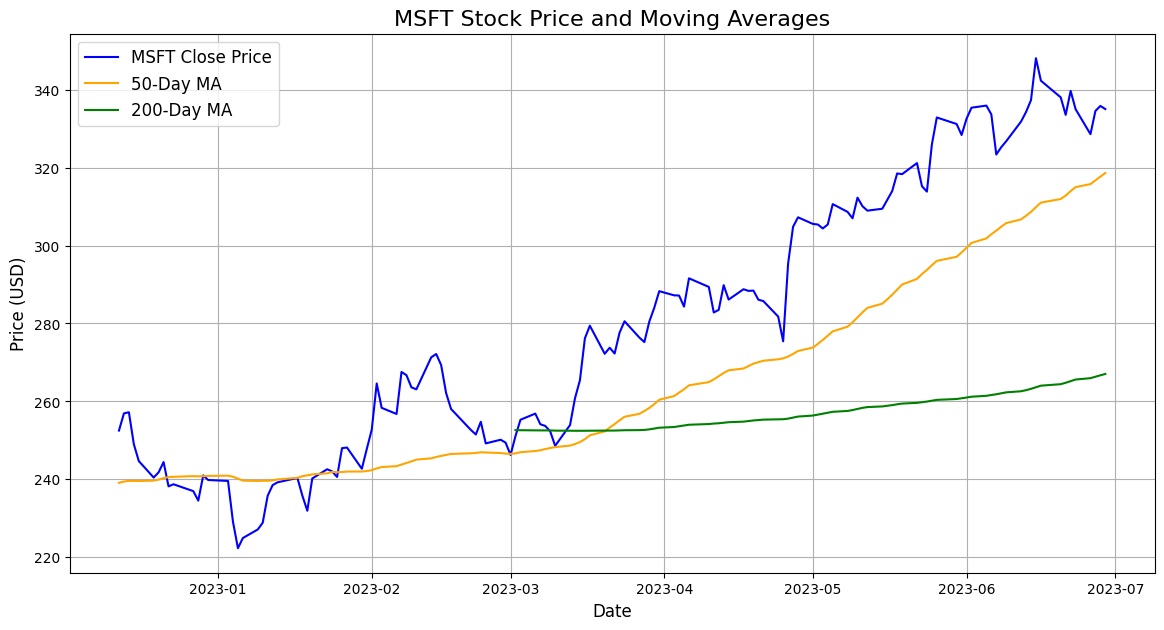

In [36]:
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta

# Define the stock and date range
stock = "MSFT"
center_date = datetime.strptime("2023-03-22 00:00:00", "%Y-%m-%d %H:%M:%S")
start_date = center_date - timedelta(days=100)
end_date = center_date + timedelta(days=100)

# Download the stock data
data = yf.download(stock, start=start_date - timedelta(days=210), end=end_date, interval="1d")

# Calculate moving averages
data['50_day_MA'] = data['Close'].rolling(window=50).mean()
data['200_day_MA'] = data['Close'].rolling(window=200).mean()

# Filter for the specified date range
plot_data = data.loc[start_date:end_date]

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(plot_data.index, plot_data['Close'], label=f'{stock} Close Price', color='blue')
plt.plot(plot_data.index, plot_data['50_day_MA'], label='50-Day MA', color='orange', linestyle='-')
plt.plot(plot_data.index, plot_data['200_day_MA'], label='200-Day MA', color='green', linestyle='-')

# Add labels, legend, and title
plt.title(f"{stock} Stock Price and Moving Averages", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price (USD)", fontsize=12)
plt.legend(loc="upper left", fontsize=12)
plt.grid(visible=True)

# Display the plot
plt.show()
